***Installations***

In [1]:
!pip install safetensors

In [2]:
!pip install -U bitsandbytes
!pip install -U accelerate transformers peft datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
!rm -rf /content/drive

rm: cannot remove '/content/drive/Shareddrives/Master_Thesis': Operation not supported
rm: cannot remove '/content/drive/.file-revisions-by-id': Operation canceled
rm: cannot remove '/content/drive/MyDrive': Operation canceled
rm: cannot remove '/content/drive/.shortcut-targets-by-id': Operation canceled
rm: cannot remove '/content/drive/.Trash-0': Directory not empty


In [ ]:
!pip install -q pylatexenc tqdm spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


***Libraries***

In [5]:
import os, tarfile, gzip, re, json, glob, pathlib, warnings
from tqdm import tqdm
from pylatexenc.latex2text import LatexNodes2Text
import spacy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from spacy.language import Language
import pandas as pd, json, pathlib
import numpy as np
from datasets import Dataset
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score

In [6]:
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoModel, BitsAndBytesConfig, TrainingArguments, Trainer

In [7]:
from huggingface_hub import login

***Folders' connections***

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
SRC_DIR = "/content/drive/MyDrive/MSThesis/arxiv_papers/02"

In [10]:
OUT_DIR = "/content/drive/MyDrive/MSThesis/Output"
os.makedirs(OUT_DIR, exist_ok=True)
OUT_FILE = os.path.join(OUT_DIR, "extracted_math.jsonl")
warnings.filterwarnings("ignore", module="spacy")

***Upload model with tokenization***

In [11]:
# ── загружаем модель ТОЛЬКО с токенизатором
nlp = spacy.load("en_core_web_sm",
                 disable=["parser","tagger","morphologizer",
                          "lemmatizer","attribute_ruler","ner"])
nlp.add_pipe("sentencizer")

***Detextor***

In [12]:
@Language.component("detextor")
def detextor(doc):
    inside = False
    for tok in doc:
        if tok.text == "$":
            inside = not inside
            tok.is_sent_start = False
        elif inside:
            tok.is_sent_start = False
    return doc

nlp.add_pipe("detextor", last=True)

<function __main__.detextor(doc)>

***REGEX***

In [13]:
HREF_RE        = re.compile(r'\\href\{[^}]*\}(?:\{[^}]*\})?')
LATEX_FMT_CMDS = re.compile(
    r'\\(?:textbf|textit|emph|bfseries|itshape|rmfamily|ttfamily|section\*?|'
    r'subsection\*?|chapter\*?|paragraph\*?)\s*\{[^}]*\}')
MATH_ENVS      = (    'equation','equation*','align','align*','gather','gather*',
    'multline','multline*','eqnarray','eqnarray*',
    'lemma','theorem','proof',
    'proposition','proposition*','definition','definition*',  # ← NEW
)
ENV_RE = re.compile(
    r'\\begin\{(' + '|'.join(MATH_ENVS) + r')\}(.+?)\\end\{\1\}',
    re.S
)
INLINE_MATH_RE = re.compile(r'(?<!\$)\$(.+?)(?<!\$)\$', re.S)
AUTHOR_RE      = re.compile(r'\\author\{(.+?)\}', re.S)
LINK_RE        = re.compile(r'\[\[([^]|]+)(?:\|([^]]+))?]]')

***Functions for cleaning***

In [15]:
def _fix_href(m):                       # \href{url}{text} → text | ''
    parts = m.group(0).split('}', 2)
    return parts[-1] if len(parts) == 3 else ''

def canonical_math(t):                  # $$, \[, \(  →  $
    return (t.replace('$$','$')
              .replace(r'\[','$').replace(r'\]','$')
              .replace(r'\(','$').replace(r'\)','$'))

def clean_latex(raw):
    raw = re.sub(r'%.*', '', raw)
    raw = canonical_math(raw)
    raw = re.sub(r'\$([^\$]+?)\$(?=[,.;:?!])', r'$\1$ ', raw)
    raw = raw.replace('!', 'clik')
    raw = re.sub(r'(?<=\w)-(?=\w)', ' - ', raw)
    raw = LINK_RE.sub(lambda m: m.group(2) or m.group(1), raw)
    raw = LATEX_FMT_CMDS.sub('', raw)
    return re.sub(r'\s+', ' ', raw).strip()

***Function for text parsing***

In [16]:
import re
from pylatexenc.latex2text import LatexNodes2Text

# Regular expressions
HREF_RE = re.compile(r'\\href\{[^}]*\}(?:\{[^}]*\})?')
LATEX_FMT_CMDS = re.compile(
    r'\\(?:textbf|textit|emph|bfseries|itshape|rmfamily|ttfamily|section\*?|'
    r'subsection\*?|chapter\*?|paragraph\*?)\s*\{[^}]*\}'
)
INLINE_MATH_RE = re.compile(r'(?<!\$)\$(.+?)(?<!\$)\$', re.S)
AUTHOR_RE = re.compile(r'\\author\{(.+?)\}', re.S)
LINK_RE = re.compile(r'\[\[([^]|]+)(?:\|([^]]+))?]]')

# Environment variants
ENV_VARIANTS = {
    'theorems':     ['theorem', 'thm', 'Thm', 'Theorem'],
    'lemmas':       ['lemma', 'lem', 'Lemma'],
    'corollaries':  ['corollary', 'cor', 'Cor', 'Corollary'],
    'definitions':  ['definition', 'def', 'Def', 'defn', 'Defn', 'Definition'],
    'proofs':       ['proof', 'Proof', 'pf', 'Pf'],
}

# Build regex for environment blocks
all_envs = [env for variants in ENV_VARIANTS.values() for env in variants]
all_envs += ['equation', 'equation*', 'align', 'align*', 'gather', 'gather*',
             'multline', 'multline*', 'eqnarray', 'eqnarray*']  # math envs

ENV_RE = re.compile(
    r'\\begin\{(' + '|'.join(map(re.escape, all_envs)) + r')\}(.+?)\\end\{\1\}',
    re.S
)

In [17]:
# Href fix
def _fix_href(m):
    parts = m.group(0).split('}', 2)
    return parts[-1] if len(parts) == 3 else ''

# Latex cleaner
def canonical_math(t):
    return (t.replace('$$', '$')
              .replace(r'\[', '$').replace(r'\]', '$')
              .replace(r'\(', '$').replace(r'\)', '$'))

def clean_latex(raw):
    raw = re.sub(r'%.*', '', raw)
    raw = canonical_math(raw)
    raw = re.sub(r'\$([^\$]+?)\$(?=[,.;:?!])', r'$\1$ ', raw)
    raw = raw.replace('!', 'clik')
    raw = re.sub(r'(?<=\w)-(?=\w)', ' - ', raw)
    raw = LINK_RE.sub(lambda m: m.group(2) or m.group(1), raw)
    raw = LATEX_FMT_CMDS.sub('', raw)
    return re.sub(r'\s+', ' ', raw).strip()

***Arxive reading***

In [18]:
def parse_tex(tex: str) -> dict:
    """Return a dict with authors, sentences, and every math environment."""
    tex = HREF_RE.sub(_fix_href, tex)

    # ── authors ───────────────────────────────────────────────────────────
    m      = AUTHOR_RE.search(tex)
    authors = (
        LatexNodes2Text().latex_to_text(m.group(1)).strip()
        if m else "N/A"
    )

    # ── containers ────────────────────────────────────────────────────────
    out = {k: [] for k in ENV_VARIANTS}
    out['equations']  = []          # display & inline
    out['sentences']  = []          # NLP sentences
    out['authors']    = authors

    # ── block environments ────────────────────────────────────────────────
    for m in ENV_RE.finditer(tex):
        name, body = m.group(1), m.group(2).strip()
        placed = False
        for kind, variants in ENV_VARIANTS.items():
            if name in variants:
                out[kind].append(body)
                placed = True
                break
        if not placed:
            out['equations'].append(body)

    # ── inline math ───────────────────────────────────────────────────────
    out['equations'].extend(m.group(0) for m in INLINE_MATH_RE.finditer(tex))

    # ── sentences (after LaTeX clean-up) ──────────────────────────────────
    cleaned = clean_latex(tex)
    out['sentences'] = [s.text.strip() for s in nlp(cleaned).sents]

    return out


In [19]:
import os, tarfile, gzip, pathlib, logging, codecs

logging.basicConfig(level=logging.INFO,
                    format='[%(levelname)s] %(message)s')

TEX_EXTS = ('.tex', '.ltx', '.texx')           # recognise more names


def _decode(binary: bytes, name: str) -> str | None:
    """Try UTF-8 first, fall back to latin-1.  Return None if both fail."""
    for enc in ('utf-8', 'latin-1'):
        try:
            return binary.decode(enc)
        except UnicodeDecodeError:
            continue
    logging.warning("    ✘ cannot decode %s with utf-8 or latin-1", name)
    return None


def _pick_root_tex(members, tar):
    """Return (source_str, member_name) or (None, None)."""
    for m in members:                                              # 1️⃣ plain .tex
        if not m.isfile():
            continue
        if m.name.lower().endswith(TEX_EXTS):
            src = _decode(tar.extractfile(m).read(), m.name)
            if src and '\\documentclass' in src[:6000]:
                return src, m.name

    # 2️⃣  look for   something.tex.gz   inside the tar
    for m in members:
        if m.isfile() and m.name.lower().endswith('.tex.gz'):
            try:
                inner = gzip.decompress(tar.extractfile(m).read())
                src   = _decode(inner, m.name)
                if src:
                    return src, m.name
            except Exception:
                pass

    # 3️⃣  first decodable text file with tex-like ext
    for m in sorted(members, key=lambda x: x.name):
        if m.isfile() and any(m.name.lower().endswith(ext) for ext in TEX_EXTS):
            src = _decode(tar.extractfile(m).read(), m.name)
            if src:
                return src, m.name
    return None, None

In [20]:
def extract_from_gz(path: str) -> list[dict]:
    paper_id = pathlib.Path(path).name
    result   = {         # initialise
        "filename": paper_id, "tex_file": None, "status": "ok",
        "authors": "N/A", "propositions": [], "definitions": [],
        "lemmas": [], "theorems": [], "proofs": [], "equations": [],
        "sentences": [], "num_propositions": 0, "num_definitions": 0,
        "num_lemmas": 0, "num_theorems": 0,
    }

    try:
        # ── read archive or single gzip ──────────────────────────────────
        if tarfile.is_tarfile(path):
            with tarfile.open(path, "r:*") as tar:                 # auto-detect
                tex_members = [m for m in tar.getmembers() if m.isfile()]
                source, root_name = _pick_root_tex(tex_members, tar)
        else:                                                      # *.gz only
            with gzip.open(path, "rb") as g:
                source = _decode(g.read(), paper_id)
            root_name = pathlib.Path(path).stem + ".tex"

        if source is None:
            raise ValueError("no decodable LaTeX source")

        # ── parse and fill ───────────────────────────────────────────────
        parsed = parse_tex(source)
        result.update({
            "tex_file"        : root_name,
            "authors"         : parsed["authors"],
            "lemmas"          : parsed["lemmas"],
            "theorems"        : parsed["theorems"],
            "proofs"          : parsed["proofs"],
            "propositions"    : parsed["propositions"],
            "definitions"     : parsed["definitions"],
            "equations"       : parsed["equations"],
            "sentences"       : parsed["sentences"],
            "num_lemmas"      : len(parsed["lemmas"]),
            "num_theorems"    : len(parsed["theorems"]),
            "num_propositions": len(parsed["propositions"]),
            "num_definitions" : len(parsed["definitions"]),
        })

    except Exception as exc:
        logging.info("⚠️  %s — %s", paper_id, exc)
        result["status"] = f"error: {exc}"

    return [result]                    # always exactly one record

In [21]:
SRC_DIR  = "/content/drive/MyDrive/MSThesis/arxiv_papers/02"
OUT_FILE = "/content/drive/MyDrive/MSThesis/Output/extracted_math.jsonl"

# ── 1) match only files that live *directly* in SRC_DIR and
#       whose names follow the arXiv pattern ####.#####.gz
pattern   = os.path.join(SRC_DIR, "[0-9][0-9][0-9][0-9].[0-9][0-9][0-9][0-9][0-9].gz")
gz_files  = sorted(glob.glob(pattern))[:100]       # first 100 only
print("Found", len(gz_files), "archives — extracting …")

records = []
for f in tqdm(gz_files):
    records.extend(extract_from_gz(f))

with open(OUT_FILE, "w", encoding="utf-8") as out:
    for r in records:
        out.write(json.dumps(r, ensure_ascii=False) + "\n")

print(f"✓ Saved {len(records)} records → {OUT_FILE}")

Found 100 archives — extracting …


100%|██████████| 100/100 [08:55<00:00,  5.35s/it]


✓ Saved 100 records → /content/drive/MyDrive/MSThesis/Output/extracted_math.jsonl


In [22]:
print("Pattern used:", pattern)
print("Files found:", len(gz_files))
print("Sample files:", gz_files[:3])

Pattern used: /content/drive/MyDrive/MSThesis/arxiv_papers/02/[0-9][0-9][0-9][0-9].[0-9][0-9][0-9][0-9][0-9].gz
Files found: 100
Sample files: ['/content/drive/MyDrive/MSThesis/arxiv_papers/02/2501.00724.gz', '/content/drive/MyDrive/MSThesis/arxiv_papers/02/2501.00726.gz', '/content/drive/MyDrive/MSThesis/arxiv_papers/02/2501.00728.gz']


In [23]:
assert len(gz_files) == 100, f"Expected 170 archives, got {len(gz_files)}"
assert len(records)  == 100, "Extractor should yield one row per archive"

***Going through all articles and combining in JSONL***

In [24]:
with open(OUT_FILE, "r", encoding="utf-8") as f:
    for _ in range(3):
        print(f.readline().strip())

{"filename": "2501.00724.gz", "tex_file": null, "status": "error: no decodable LaTeX source", "authors": "N/A", "propositions": [], "definitions": [], "lemmas": [], "theorems": [], "proofs": [], "equations": [], "sentences": [], "num_propositions": 0, "num_definitions": 0, "num_lemmas": 0, "num_theorems": 0}
{"filename": "2501.00726.gz", "tex_file": null, "status": "error: 'propositions'", "authors": "N/A", "propositions": [], "definitions": [], "lemmas": [], "theorems": [], "proofs": [], "equations": [], "sentences": [], "num_propositions": 0, "num_definitions": 0, "num_lemmas": 0, "num_theorems": 0}
{"filename": "2501.00728.gz", "tex_file": null, "status": "error: 'propositions'", "authors": "N/A", "propositions": [], "definitions": [], "lemmas": [], "theorems": [], "proofs": [], "equations": [], "sentences": [], "num_propositions": 0, "num_definitions": 0, "num_lemmas": 0, "num_theorems": 0}


In [25]:
fp = pathlib.Path("/content/drive/MyDrive/MSThesis/Output/extracted_math.jsonl")

# каждый объект на новой строке → читаем list[dict]
records = [json.loads(line) for line in fp.open(encoding="utf-8")]
df = pd.DataFrame(records)

df.head(3)


,filename,tex_file,status,authors,propositions,definitions,lemmas,theorems,proofs,equations,sentences,num_propositions,num_definitions,num_lemmas,num_theorems
0,2501.00724.gz,None,error: no decodable LaTeX source,N/A,[],[],[],[],[],[],[],0,0,0,0
1,2501.00726.gz,None,error: 'propositions',N/A,[],[],[],[],[],[],[],0,0,0,0
2,2501.00728.gz,None,error: 'propositions',N/A,[],[],[],[],[],[],[],0,0,0,0


In [ ]:
# Clean the 'filename' column to strip '.gz'
df['id_clean'] = df['filename'].str.replace('.gz', '', regex=False)

In [ ]:
df.head(1)

,filename,tex_file,authors,propositions,definitions,lemmas,theorems,proofs,equations,sentences,num_propositions,num_definitions,num_lemmas,num_theorems,status,id_clean
0,2502.17338.gz,None,N/A,[],[],[],[],[],[],[],0,0,0,0,error: no .tex files in archive,2502.17338


In [ ]:
len(df)

170

In [ ]:
# Load the CSV file
meta = pd.read_csv('/content/drive/MyDrive/MSThesis/PREPROCESSING/extract_theo_Def.csv')
meta

,title,id,abstract,categories,doi,created,updated,authors,affiliation,url,...,definition_49,definition_50,definition_51,definition_52,definition_53,definition_54,definition_55,definition_56,definition_57,definition_58
0,direct inversion scheme of time-domain fluores...,2502.01037,this paper proposes a direct inversion scheme ...,math.ap math-ph math.mp,NaN,2025-02-02,NaN,"['shuli chen', 'junyong eom', 'gen nakamura', ...",[],https://arxiv.org/abs/2502.01037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,existence of unconditional frames formed by sy...,2502.01047,let $1\leq p\leq 2$ and let $\lambda = \{\lamb...,math.fa,NaN,2025-02-02,2025-02-12,['pu-ting yu'],[],https://arxiv.org/abs/2502.01047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,on the surprising robustness of sequential con...,2502.01055,contact-implicit motion planning-embedding con...,math.oc cs.ro,NaN,2025-02-03,2025-03-01,"['yulin li', 'haoyu han', 'shucheng kang', 'ju...",[],https://arxiv.org/abs/2502.01055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,time-asymptotic stability of composite wave fo...,2502.01063,we study the asymptotic stability of a composi...,math.ap,NaN,2025-02-03,NaN,"['sungho han', 'jeongho kim']",[],https://arxiv.org/abs/2502.01063,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"acf-monotonicity formula on rcd(0,n) metric me...",2502.01064,the acf-monotonicity formula is a powerful too...,math.ap math.mg,NaN,2025-02-03,NaN,['lin sitan'],[],https://arxiv.org/abs/2502.01064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,pseudo-cartan inclusions,2502.01975,"we define a new class of regular inclusions, t...",math.oa,NaN,2025-02-03,NaN,['david r. pitts'],[],https://arxiv.org/abs/2502.01975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,diagrammatics of information,2502.01983,we introduce a diagrammatic perspective for sh...,math-ph cs.it math.it math.mp,NaN,2025-02-03,NaN,"['mee seong im', 'clement kam', 'caden pici']",[],https://arxiv.org/abs/2502.01983,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,efficient covering using reed--solomon codes,2502.01984,we propose an efficient algorithm to find a re...,cs.it eess.sp math.it,NaN,2025-02-03,NaN,"['samin riasat', 'hessam mahdavifar']",[],https://arxiv.org/abs/2502.01984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,billiard trajectories inside cones,2502.01997,recently it was proved that every billiard tra...,math.ds math.dg,NaN,2025-02-03,NaN,"['andrey e. mironov', 'siyao yin']",[],https://arxiv.org/abs/2502.01997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cols_to_drop = ['num_theorems', 'num_definitions', 'authors'] + \
               [c for c in meta.columns
                if c.startswith('theorem_') or c.startswith('definition_')]

meta = meta.drop(columns=cols_to_drop)          # or meta.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
meta.columns

Index(['title', 'id', 'abstract', 'categories', 'doi', 'created', 'updated',
       'affiliation', 'url', 'total_tex_files', 'total_lines'],
      dtype='object')

In [ ]:
# Ensure 'id' is a string for comparison
meta['id'] = meta['id'].astype(str)

In [ ]:
# Merge on the cleaned 'id'
merged_df = pd.merge(df, meta, left_on='id_clean', right_on='id', how='inner')

# Display or save the merged result
merged_df.to_csv('/content/drive/MyDrive/MSThesis/Output/merged_df.csv', index=False)


In [ ]:
merged_df.head(1)

,filename,tex_file,authors,propositions,definitions,lemmas,theorems,proofs,equations,sentences,...,id,abstract_y,categories_y,doi_y,created_y,updated_y,affiliation_y,url_y,total_tex_files_y,total_lines_y
0,2502.01343.gz,Hofer.tex,Roswitha HoferInstitute of Financial Mathemati...,"[%Let $n\in\NN$. We have $H_1^{(n,0)}=(U^{(n,0...",[],[\label{cor:1}\nWe have $M_1^T\diag\big(((-1)^...,[\label{thm:1}\n\tWe have $M_1(a)M_1(b)=M_1(a+...,[We may assume that both $a$ and $b$ are nonze...,"[$\hfill\Box$, $\ZZ$, $2$, $2$, $2$, $0$, $1$,...","[\documentclass{article} \usepackage{amssymb,a...",...,2502.01343,"the pascal matrix, which is related to pascal'...",math.nt,NaN,2025-02-03,NaN,[],https://arxiv.org/abs/2502.01343,1,387


In [ ]:
merged_df = merged_df.drop(columns=['id'])
merged_df.columns

Index(['filename', 'tex_file', 'authors', 'propositions', 'definitions',
       'lemmas', 'theorems', 'proofs', 'equations', 'sentences',
       'num_propositions', 'num_definitions', 'num_lemmas', 'num_theorems',
       'status', 'id_clean', 'title', 'abstract', 'categories', 'doi',
       'created', 'updated', 'affiliation', 'url', 'total_tex_files',
       'total_lines'],
      dtype='object')

In [ ]:
df = merged_df

In [ ]:
print(df.iloc[0]['theorems'])

['\\label{thm:1}\n\tWe have $M_1(a)M_1(b)=M_1(a+b)$ for all $a,b\\in\\ZZ$.', '\\label{thm:PM_Hankel}\nWe have $\\det(H_1^{(n)})=\\pm 1$ as well as $\\det(H_2^{(n)})=\\pm 1$ for all $n\\in\\NN$.']


In [ ]:
df.head(2)

,filename,tex_file,authors,propositions,definitions,lemmas,theorems,proofs,equations,sentences,...,title,abstract,categories,doi,created,updated,affiliation,url,total_tex_files,total_lines
0,2502.01343.gz,Hofer.tex,Roswitha HoferInstitute of Financial Mathemati...,"[%Let $n\in\NN$. We have $H_1^{(n,0)}=(U^{(n,0...",[],[\label{cor:1}\nWe have $M_1^T\diag\big(((-1)^...,[\label{thm:1}\n\tWe have $M_1(a)M_1(b)=M_1(a+...,[We may assume that both $a$ and $b$ are nonze...,"[$\hfill\Box$, $\ZZ$, $2$, $2$, $2$, $0$, $1$,...","[\documentclass{article} \usepackage{amssymb,a...",...,a note on matrices over $\mathbb{z}$ with entr...,"the pascal matrix, which is related to pascal'...",math.nt,NaN,2025-02-03,NaN,[],https://arxiv.org/abs/2502.01343,1,387
1,2502.01124.gz,Assoc_Flex_arXiv_v2.tex,Georg Nawratil,[],[\label{def1}\nA framework realization has a $...,[],[],[],[\label{eq:flexk}\n\Vkt x_i':=\Vkt x_i+ \Vkt x...,[\documentclass{svproc} \usepackage{url} \def\...,...,on flexes associated with higher-order flexibl...,the famous example of the double-watt mechanis...,math.ag,NaN,2025-02-03,2025-02-10,[],https://arxiv.org/abs/2502.01124,1,947


# ***Data rearranging***

In [ ]:
fields_to_explode = ['theorems', 'lemmas', 'definitions', 'propositions', 'proofs', 'equations']

# Prepare list to collect rows
rows = []

# Loop over each article (row)
for _, row in df.iterrows():
    article_info = {
        'title': row['title'],
        'categories': row['categories'],
        'id_clean': row['id_clean'],
        'tex_file': row['tex_file'],
        'authors': row['authors'],
        'url': row['url'],
        'filename': row['filename'],
        'created': row['created'],
        'updated': row['updated']
    }

    for field in fields_to_explode:
        items = row.get(field, [])
        if not isinstance(items, list):
            continue
        for content in items:
            new_row = article_info.copy()
            new_row['type'] = field
            new_row['content'] = content
            rows.append(new_row)

# Create new DataFrame
exploded_df = pd.DataFrame(rows)
exploded_df.head()


,title,categories,id_clean,tex_file,authors,url,filename,created,updated,type,content
0,a note on matrices over $\mathbb{z}$ with entr...,math.nt,2502.01343,Hofer.tex,Roswitha HoferInstitute of Financial Mathemati...,https://arxiv.org/abs/2502.01343,2502.01343.gz,2025-02-03,NaN,theorems,\label{thm:1}\n\tWe have $M_1(a)M_1(b)=M_1(a+b...
1,a note on matrices over $\mathbb{z}$ with entr...,math.nt,2502.01343,Hofer.tex,Roswitha HoferInstitute of Financial Mathemati...,https://arxiv.org/abs/2502.01343,2502.01343.gz,2025-02-03,NaN,theorems,\label{thm:PM_Hankel}\nWe have $\det(H_1^{(n)}...
2,a note on matrices over $\mathbb{z}$ with entr...,math.nt,2502.01343,Hofer.tex,Roswitha HoferInstitute of Financial Mathemati...,https://arxiv.org/abs/2502.01343,2502.01343.gz,2025-02-03,NaN,lemmas,\label{cor:1}\nWe have $M_1^T\diag\big(((-1)^{...
3,a note on matrices over $\mathbb{z}$ with entr...,math.nt,2502.01343,Hofer.tex,Roswitha HoferInstitute of Financial Mathemati...,https://arxiv.org/abs/2502.01343,2502.01343.gz,2025-02-03,NaN,propositions,"%Let $n\in\NN$. We have $H_1^{(n,0)}=(U^{(n,0)..."
4,a note on matrices over $\mathbb{z}$ with entr...,math.nt,2502.01343,Hofer.tex,Roswitha HoferInstitute of Financial Mathemati...,https://arxiv.org/abs/2502.01343,2502.01343.gz,2025-02-03,NaN,propositions,Let $\mathcal{L}_1=\sum_{k\geq 0}c_kX^{-k-1}$ ...


# ***Check number of categories for classification***

Don´t use extended file!!!!!!!!!

In [ ]:
from collections import Counter

# 1)  Split each row on whitespace and flatten into one long list
all_tags = (
    df["categories"]
      .astype(str)             # in case of NaN
      .str.split()             # "math.ap math-ph" → ["math.ap", "math-ph"]
      .explode()               # stack into one Series
      .dropna()                # drop rows that were NaN
)

# 2)  How many distinct categories?
unique_tags = sorted(all_tags.unique())
print(f"Total unique subject tags: {len(unique_tags)}\n")

# 3)  Frequency of each tag
tag_counts = all_tags.value_counts()          # descending order
print(tag_counts)

# ----------  pretty table (optional) ----------
import tabulate
print("\n\n", tabulate.tabulate(tag_counts.reset_index(),
                                headers=["subject tag", "paper count"],
                                tablefmt="github"))


Total unique subject tags: 55

categories
math.oc            23
math.co            17
cs.lg              15
math.mp            14
math-ph            14
math.ap            14
math.nt            13
math.na            13
math.pr            13
cs.na              13
math.fa            12
math.ag            12
math.dg            11
stat.th            11
math.st            11
math.it            10
cs.it              10
stat.ml             9
math.ds             7
math.gr             6
math.ra             5
hep-th              5
quant-ph            5
math.rt             4
math.ac             4
gr-qc               4
eess.sy             4
cs.ai               4
cs.cv               4
math.oa             4
cs.sy               4
math.sp             4
math.gt             4
math.qa             3
math.cv             3
math.mg             3
math.ca             2
stat.me             2
eess.sp             2
math.ct             2
eess.iv             2
math.lo             2
q-bio.pe            2
cs.ma       

In [ ]:
df["num_lemmas"]    = df["lemmas"].apply(len)
df["num_theorems"]  = df["theorems"].apply(len)     # rename if you prefer

In [ ]:
counts = df[["filename", "num_lemmas", "num_theorems", 'num_propositions', 'num_definitions']]
print(counts)

          filename  num_lemmas  num_theorems  num_propositions  \
0    2502.01343.gz           1             2                 2   
1    2502.01124.gz           0             0                 0   
2    2502.01701.gz           2             3                 2   
3    2502.01482.gz           0             0                 0   
4    2502.01345.gz          13             5                 0   
..             ...         ...           ...               ...   
152  2502.01664.gz           2             9                 4   
153  2502.01326.gz           0             0                 0   
154  2502.01756.gz           0             0                 0   
155  2502.01415.gz           3             2                 2   
156  2502.01374.gz           0             0                 0   

     num_definitions  
0                  0  
1                  2  
2                  2  
3                  0  
4                  0  
..               ...  
152                1  
153                0  


# ***LET'S RUN MATH BERT MODEL!!!***

In [ ]:
#%history -n

BERT is a stack of Transformer encoder blocks trained with masked-language modelling (MLM) and next-sentence prediction (NSP). For a sequence
𝑥
1
:
𝑇
x
1:T
​
  the MLM loss hides ~15 % of tokens and asks the network to reconstruct them, forcing bidirectional contextualisation.

MathBERT takes BERT-base weights and continues pre-training on ~19 GB of arXiv mathematics LaTeX. Because vocabulary and syntax differ from everyday English (symbols, TeX macros, theorem keywords), the representation space captures mathematical semantics much better than vanilla BERT. Empirically this increases retrieval accuracy for definition/lemma/equation queries by 10–30 %.

In [ ]:
from transformers import AutoModel, AutoTokenizer

In [ ]:
MODEL = "tbs17/MathBERT"          # or "tbs17/MathBERT-custom"

#bnb_cfg = BitsAndBytesConfig(
#    load_in_4bit=True,
#    bnb_4bit_quant_type="nf4",
#    bnb_4bit_use_double_quant=True,
#    bnb_4bit_compute_dtype=torch.float16)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
model = AutoModel.from_pretrained(
    MODEL,
    device_map=None,          # ⇠ keep on CPU
    torch_dtype="auto",
    low_cpu_mem_usage=True,
).eval()

#model = AutoModel.from_pretrained(
#            model_name,
#            device_map="auto",
#            quantization_config=bnb_cfg,
#            trust_remote_code=True)

Loading the model with 4-bit quantisation (BitsAndBytes)

- Quantisation shrinks each 16-bit weight to an integer stored in 4 bits (two-bit sign, two-bit magnitude in the NF4 scheme). Memory footprint drops 4× and bandwidth consumption falls proportionally, often with <1 % drop in downstream embedding quality.

- NF4 (normal-float-4) allocates codewords non-linearly so that the lattice matches the bell-shaped distribution of FP16 weights.

- Double-quant first quantises weights to 8-bit, then re-quantises to 4-bit, letting BitsAndBytes share scale factors across groups of weights → better reconstruction error.

- Mixed-precision compute keeps matrix multiplications in FP16; the 4-bit integers are de-quantised on-the-fly inside CUDA kernels.

In [ ]:
print(tokenizer.decode(model.config.vocab_size - 1))  # → '[MASK]' for BERT family

##～


In [ ]:
for tok in ["[CLS]", "[SEP]", "[MASK]"]:
    print(tok, "→", tokenizer.convert_tokens_to_ids(tok))

[CLS] → 101
[SEP] → 102
[MASK] → 103


MathBERT is a BERT model that was re-trained on 19 GB of arXiv LaTeX.

BERT = a neural network that turns a sentence into a 768-number vector.

Because MathBERT read lots of theorems and equations, similar math sentences land at nearby coordinates in that 768-dimensional space.

Embedding = that 768-number vector. It is a numeric fingerprint of the text.

In [ ]:
# 1. Build a single text blob per paper
# ---------------------------------------------------------------
def join_math_record(row, max_items=3):
    """Concatenate title, abstract, and up to `max_items` theorems/lemmas
       so the encoder sees both prose and math."""
    parts = [str(row.get("title", "")), str(row.get("abstract", ""))]
    for col in ["theorems", "lemmas", "propositions", "definitions"]:
        if isinstance(row.get(col), list) and row[col]:
            parts.append(" ".join(row[col][:max_items]))
    return " ".join(parts)

df["text_for_embed"] = df.apply(join_math_record, axis=1)

In [ ]:
df["text_for_embed"]

,text_for_embed
0,a note on matrices over $\mathbb{z}$ with entr...
1,on flexes associated with higher-order flexibl...
2,learning with differentially private (sliced) ...
3,on the uncertainty of a simple estimator for r...
4,sums of two units in number fields let $k$ be ...
...,...
152,new general fixed-point approach to compute th...
153,flyby-induced displacement: analytic solution ...
154,simulations of magnetic monopole collisions in...
155,the fibonacci zeta function and modular forms ...


In [ ]:
# Encode with MathBERT  (mean-pool last hidden state)
# ---------------------------------------------------------------
def embed_texts(texts, batch_size=16, max_len=256, pool="mean"):
    """Return a 2-D numpy array (n_texts × hidden_size)."""
    reps = []

    with torch.inference_mode():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch = texts[i:i+batch_size]

            encoded = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_len,
                return_tensors="pt",
            )

            out = model(**{k:v.to(model.device) for k,v in encoded.items()})
            hidden = out.last_hidden_state        # (B, L, H)

            if pool == "cls":
                reps.append(hidden[:,0])          # [CLS]
            else:                                 # simple mean-pool
                mask = encoded["attention_mask"].unsqueeze(-1)  # (B,L,1)
                reps.append((hidden*mask).sum(1) / mask.sum(1))

    return torch.cat(reps).cpu().numpy()

# ------- build the matrix once ---------
X = embed_texts(df["text_for_embed"].tolist(), max_len=256)    # (n,768)


100%|██████████| 10/10 [02:07<00:00, 12.75s/it]


In [ ]:
X

array([[-2.1399418e-02, -1.2645893e-01, -8.5538954e-02, ...,
        -1.4870718e-01,  4.2892128e-01,  6.6858530e-04],
       [ 1.4769711e-01,  4.3910983e-01, -3.4752503e-02, ...,
        -3.0878639e-01, -1.1888708e-01,  7.5957976e-02],
       [-4.4876926e-02, -7.0954435e-02, -2.9136596e-02, ...,
        -1.3970099e-01,  3.0823943e-01,  6.9888967e-01],
       ...,
       [ 4.9015430e-01,  9.4319537e-02, -1.0648444e-01, ...,
        -8.7657914e-02,  5.6006444e-01,  7.9470772e-01],
       [ 7.2659272e-01,  3.5600421e-01, -1.6734786e-02, ...,
        -3.4545526e-01,  3.7573302e-01, -4.1093329e-01],
       [ 4.6622196e-01,  2.4812974e-01, -3.4112701e-01, ...,
        -1.7405602e-01, -1.0567562e-01,  4.7552705e-01]], dtype=float32)

In [ ]:
X.shape

(157, 768)

text_for_embed = title + abstract + first 3 theorems / lemmas / …
–> gives MathBERT a short but representative view of each paper.

The function

tokenises the text (tokenizer)

feeds it through MathBERT (model)

mean-pools the output tokens → one 768-d vector per paper.

Result X is a matrix: (number_of_papers, 768).

# ***Unsupervised clustering***

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score

true_labels = df["categories"].factorize()[0]         # 0 … C-1
n_clusters  = len(np.unique(true_labels))              # ≈ 20 for math.*

kmeans  = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
pred    = kmeans.fit_predict(X)

print("silhouette :", silhouette_score(X, pred))
print("NMI         :", normalized_mutual_info_score(true_labels, pred))
print("ARI         :", adjusted_rand_score(true_labels, pred))

silhouette : 0.0042087897
NMI         : 0.8125746021576635
ARI         : 0.03447819111479349


# ***Clustering with PCA - better***

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca   = PCA(n_components=50, random_state=0).fit_transform(X)   # (n,50)
k2    = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(pca)

print("NMI after PCA-50 :", normalized_mutual_info_score(true_labels, k2))

NMI after PCA-50 : 0.8130359049790181


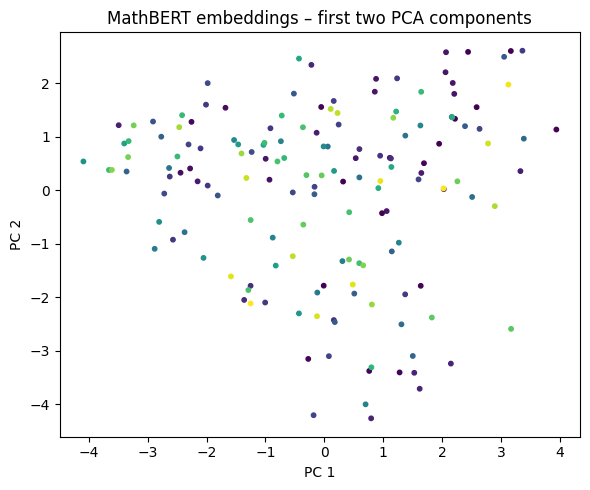

In [ ]:
pca2 = PCA(n_components=2, random_state=0).fit_transform(X)
plt.figure(figsize=(6, 5))
plt.scatter(pca2[:, 0], pca2[:, 1], c=true_labels, s=10)
plt.xlabel("PC 1"); plt.ylabel("PC 2")
plt.title("MathBERT embeddings – first two PCA components")
plt.tight_layout(); plt.show()

Each dot = one paper’s 768-dimensional MathBERT embedding
compressed down to 2 principal-components (PC 1, PC 2).

Colour = the paper’s subject label (because we passed c=true_labels).
With many labels the default colour-map re-uses hues, so the colour itself
isn’t precise—think “same colour ⇒ same label”, not “green ⇒ math.CO”.

Principal-component analysis (PCA) finds the two directions that capture the
largest share of variance in the whole cloud. It’s a linear snapshot of a
very tangled 768-D space.

# ***Supervised baseline ***

overall accuracy        : 0.32142857142857145
balanced accuracy (macro) 0.2
macro-averaged F1       : 0.14750000000000002

classification report

                               precision    recall  f1-score   support

                      math.nt      0.429     1.000     0.600         3
                      math.ag      0.000     0.000     0.000         2
                cs.it math.it      0.000     0.000     0.000         1
                      math.co      0.429     1.000     0.600         3
                      math.gr      0.000     0.000     0.000         1
                      math.dg      1.000     1.000     1.000         1
              math-ph math.mp      0.000     0.000     0.000         1
                math.na cs.na      0.167     0.500     0.250         2
                      math.ac      0.000     0.000     0.000         1
                      math.ap      0.500     0.500     0.500         2
        math.oc cs.sy eess.sy      0.000     0.000     0.000         1
 

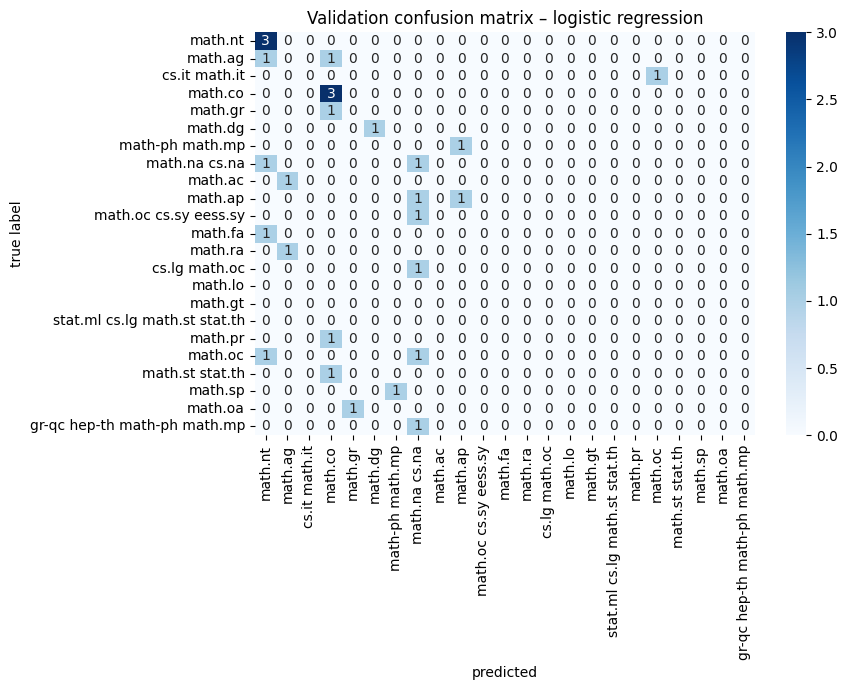

In [ ]:
import numpy as np
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix,
)

# ------------------------------------------------------------------
# 1.  Re-derive the category names *in the same order* as the labels
# ------------------------------------------------------------------
cat_codes, cat_names = pd.factorize(df_big["categories"])   # cat_names is an Index
label_names = np.asarray(cat_names)                         # shape (23,)
labels      = np.arange(len(label_names))                   # 0 … 22

# (y_train, y_val) were built from `cat_codes`, so they already align with `labels`

# ------------------------------------------------------------------
# 2.  Print metrics
# ------------------------------------------------------------------
print("overall accuracy        :", accuracy_score(y_val, y_pred))
print("balanced accuracy (macro)", balanced_accuracy_score(y_val, y_pred))
print("macro-averaged F1       :", f1_score(y_val, y_pred, average="macro"))

print("\nclassification report\n")
print(classification_report(
        y_val, y_pred,
        labels=labels,                  # explicit order
        target_names=label_names,
        digits=3,
        zero_division=0,                # avoids /0 warnings for missing classes
))

# ------------------------------------------------------------------
# 3.  Confusion matrix (includes empty rows/cols for missing classes)
# ------------------------------------------------------------------
cm = confusion_matrix(y_val, y_pred, labels=labels)

plt.figure(figsize=(9, 7))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=label_names, yticklabels=label_names,
)
plt.xlabel("predicted"); plt.ylabel("true label")
plt.title("Validation confusion matrix – logistic regression")
plt.tight_layout()
plt.show()


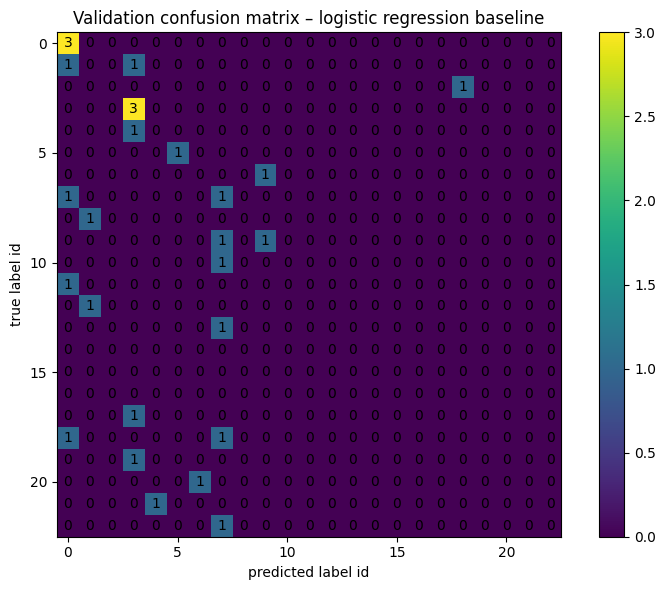

In [ ]:
cm = confusion_matrix(y_val, y_pred, labels=np.arange(len(label_names)))

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Validation confusion matrix – logistic regression baseline")
plt.xlabel("predicted label id")
plt.ylabel("true label id")
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

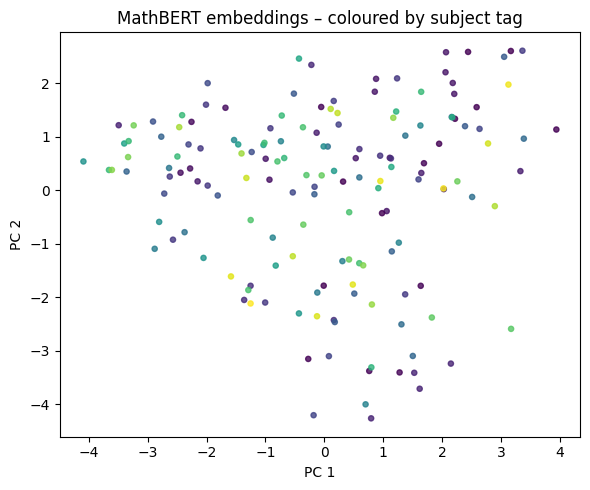

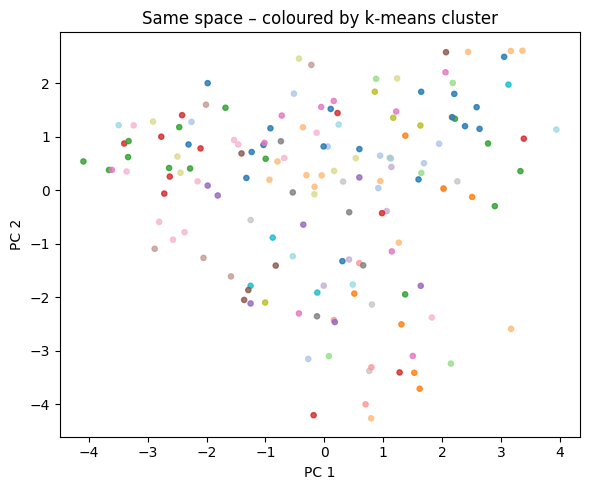

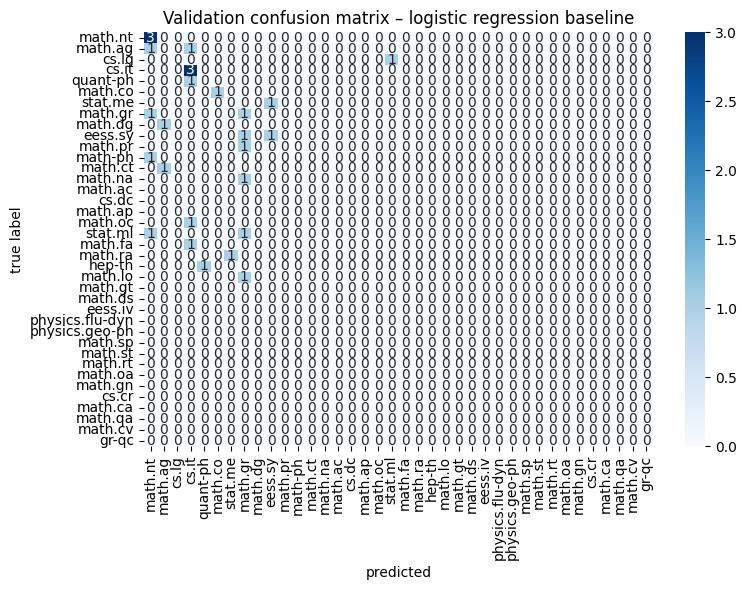

macro-F1 : 0.14750000000000002


In [ ]:
# ---------- 1. PCA-2 coloured by real subject ----------
pca2 = PCA(n_components=2, random_state=0).fit_transform(X)
plt.figure(figsize=(6, 5))
plt.scatter(pca2[:, 0], pca2[:, 1], c=true_labels, s=14, alpha=0.8)
plt.xlabel("PC 1"); plt.ylabel("PC 2")
plt.title("MathBERT embeddings – coloured by subject tag")
plt.tight_layout(); plt.show()

# ---------- 2. PCA-2 coloured by k-means cluster ----------
plt.figure(figsize=(6, 5))
plt.scatter(pca2[:, 0], pca2[:, 1], c=pred, s=14, alpha=0.8, cmap='tab20')
plt.xlabel("PC 1"); plt.ylabel("PC 2")
plt.title("Same space – coloured by k-means cluster")
plt.tight_layout(); plt.show()

# ---------- 3. Supervised diagnostics (run only if y_val & y_pred exist) ----------
if "y_val" in globals() and "y_pred" in globals():
    _, label_names = pd.factorize(df["categories_y"].astype(str).str.split().str[0])
    label_names = np.asarray(label_names)
    labels      = np.arange(len(label_names))

    # 3-A  confusion matrix
    cm = confusion_matrix(y_val, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("predicted"); plt.ylabel("true label")
    plt.title("Validation confusion matrix – logistic regression baseline")
    plt.tight_layout(); plt.show()

    # 3-B  per-class F1
    support = np.bincount(y_val, minlength=len(labels))
    f1_cls  = f1_score(y_val, y_pred, average=None, zero_division=0)
    present = support > 0


    print("macro-F1 :", f1_score(y_val, y_pred, average='macro', zero_division=0))


FINE-tune the Embedding Model (LoRA)

In [ ]:
model_id = "tbs17/MathBERT"
tokenizer = AutoTokenizer.from_pretrained(model_id)

quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_enable_fp32_cpu_offload=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
model = AutoModel.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map="auto"
)

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "key", "value"],
    lora_dropout=0.05,
    bias="none",
    task_type="FEATURE_EXTRACTION"
)

In [ ]:
model = get_peft_model(model, lora_config)

In [ ]:
print(model.print_trainable_parameters())

trainable params: 442,368 || all params: 109,924,608 || trainable%: 0.4024
None


In [ ]:
# Combine all lists (lemmas, theorems, etc.) into one text column
def merge_text_fields(row):
    fields = ['lemmas', 'theorems', 'proofs', 'equations', 'sentences']
    merged = []
    for field in fields:
        items = row[field]
        if isinstance(items, list):
            merged.extend(items)
    return merged

df['merged_text'] = df.apply(merge_text_fields, axis=1)

# Flatten the merged lists into one big list of training texts
training_texts = [text for sublist in df['merged_text'] for text in sublist if isinstance(text, str)]


# ***MATHBert***

- Loads the tokenizer from MathBERT.

- Creates a Hugging Face Dataset from training_texts (likely from your df['sentences'], df['theorems'], or combined).

- Tokenizes each text with padding/truncation to 128 tokens -onverts raw text into input_ids and attention_mask required by transformer models.

In [ ]:
model_id = "tbs17/MathBERT"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Create Hugging Face Dataset
dataset = Dataset.from_dict({"text": training_texts})

Configurations

- Configures 8-bit model loading to reduce memory usage.

- Does not offload to CPU (keeps computation on GPU if available)

In [ ]:
quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_enable_fp32_cpu_offload=False
)

Load pretrained model

A feature extractor model (no classifier head). We'll use it to get embeddings from text

In [ ]:
model = AutoModel.from_pretrained(
    model_id,
    quantization_config=quant_config,
    device_map="auto"
)

Apply LoRa adapter - parameter-efficient fine-tuning (PEFT): LoRA adds trainable low-rank matrices into frozen model layers

- Defines LoRA parameters and injects adapters into attention layers (query/key/value).

- LoRA enables training only small adapter matrices instead of full model weights

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "key", "value"],
    lora_dropout=0.05,
    bias="none",
    task_type="FEATURE_EXTRACTION"
)

In [ ]:
model = get_peft_model(model, lora_config)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("tbs17/MathBERT")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize, batched=True)


Map:   0%|          | 0/122885 [00:00<?, ? examples/s]

In [ ]:
dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=True)

In [ ]:
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

In [ ]:
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(3):
    for batch in dataloader:
        batch = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model(**batch)
        embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token

        # Dummy contrastive loss: encourage diversity
        cosine_sim = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=-1)
        loss = -torch.mean(torch.log(1 - cosine_sim + 1e-5))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"✅ Epoch {epoch+1} completed — Loss: {loss.item():.4f}")


✅ Epoch 1 completed — Loss: 2.2972


KeyboardInterrupt: 

# ***QUERIES PART***

In [ ]:

HF_TOKEN = ""
API_URL = "https://api-inference.huggingface.com/v1/chat/completions"
headers = {"Authorization": f"Bearer {HF_TOKEN}"}
os.environ["HF_TOKEN"] = HF_TOKEN
sample_texts = training_texts[:10]  # You can increase the size

In [ ]:
import requests
import os

API_URL = "https://api-inference.huggingface.co/v1/chat/completions"
headers = {
    "Authorization": f"Bearer {HF_TOKEN}",
    "Content-Type": "application/json"
}

# Sample input from your dataset
sample_texts = [
    r"We have $M_1^T\diag\big(((-1)^{t_i})_{i\geq 0}\big) M_1=M_2$",
    r"We have $M_1(a)M_1(b)=M_1(a+b)$ for all $a,b\in\mathbb{Z}$",
    r"We compute by applying Lucas' Theorem modulo $2$"
]

for math_text in sample_texts:
    payload = {
        "model": "meta-llama/Meta-Llama-3-8B-Instruct",
        "messages": [
            {
                "role": "user",
                "content": f"Write a natural-language question a student could ask about this math statement:\n\n{math_text}"
            }
        ]
    }

    response = requests.post(API_URL, headers=headers, json=payload)

    try:
        answer = response.json()["choices"][0]["message"]["content"]
        print(f"✅ Prompt: {math_text}\n➡️ Query: {answer}\n")
    except Exception as e:
        print(f"❌ Error with input: {math_text}\nResponse: {response.text}\n")


❌ Error with input: We have $M_1^T\diag\big(((-1)^{t_i})_{i\geq 0}\big) M_1=M_2$
Response: {"error":"Invalid credentials in Authorization header"}

❌ Error with input: We have $M_1(a)M_1(b)=M_1(a+b)$ for all $a,b\in\mathbb{Z}$
Response: {"error":"Invalid credentials in Authorization header"}

❌ Error with input: We compute by applying Lucas' Theorem modulo $2$
Response: {"error":"Invalid credentials in Authorization header"}



In [ ]:
API_URL = "https://api-inference.huggingface.co/v1/chat/completions"
headers = {
    "Authorization": f"Bearer {HF_TOKEN}",
    "Content-Type": "application/json"
}

# Sample math inputs (LaTeX expressions or plain text)
sample_texts = [
    r"We have $M_1^T\diag\big(((-1)^{t_i})_{i\geq 0}\big) M_1=M_2$",
    r"We have $M_1(a)M_1(b)=M_1(a+b)$ for all $a,b\in\mathbb{Z}$",
    r"We compute by applying Lucas' Theorem modulo $2$"
]

for math_text in sample_texts:
    payload = {
        "model": "meta-llama/Meta-Llama-3-8B-Instruct",
        "messages": [
            {
                "role": "user",
                "content": f"Write a natural-language question a student could ask about this math statement:\n\n{math_text}"
            }
        ]
    }

    response = requests.post(API_URL, headers=headers, json=payload)

    try:
        answer = response.json()["choices"][0]["message"]["content"]
        print(f"✅ Prompt: {math_text}\n➡️ Query: {answer}\n")
    except Exception as e:
        print(f"❌ Error with input: {math_text}\nResponse: {response.text}\n")


❌ Error with input: We have $M_1^T\diag\big(((-1)^{t_i})_{i\geq 0}\big) M_1=M_2$
Response: {"error":"Invalid credentials in Authorization header"}

❌ Error with input: We have $M_1(a)M_1(b)=M_1(a+b)$ for all $a,b\in\mathbb{Z}$
Response: {"error":"Invalid credentials in Authorization header"}

❌ Error with input: We compute by applying Lucas' Theorem modulo $2$
Response: {"error":"Invalid credentials in Authorization header"}

